<h1>Exercise 5</h1> 

In [41]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
import random

In [42]:
class AgentState(TypedDict):
    target: int
    playerName: str
    guesses: List[int]
    attempts: int
    lowerBound: int
    upperBound: int
    result: str

In [43]:
def setupNode(state: AgentState) -> AgentState:
    """Initialises "attempts" to 1, sets the lower and upper bounds, and initialises "result for first attempt"""
    state["attempts"] = 1
    state["lowerBound"] = 1
    state["upperBound"] = 20
    state["result"] = f"Hi {state["playerName"]} !, attempt number: {state["attempts"]}, choosing a number between {state["lowerBound"]} and {state["upperBound"]}."
    print(state["result"] + "\n")
    return state

In [44]:
def guessNode(state: AgentState) -> AgentState:
    """guesses a no. between the current upper and lower bound"""
    guess = random.randint(state["lowerBound"], state["upperBound"])
    print(f"Current guess: {guess} \n")
    state["guesses"].append(guess)
    return state

In [45]:
def hintNode(state: AgentState) -> AgentState:
    """evaluates the guess and gives a hint"""
    if (state["attempts"] > 7):
        state["result"] = "over"
        return state
    
    elif (state["guesses"][len(state["guesses"])-1] == state["target"]):
        state["result"] = "foundIt"
        return state
    
    elif (state["guesses"][len(state["guesses"])-1] > state["target"]):
        state["upperBound"] = state["guesses"][len(state["guesses"])-1]
        state["attempts"] += 1
        state["result"] = "lower"
        return state
    
    else:
        state["lowerBound"] = state["guesses"][len(state["guesses"])-1]
        state["attempts"] += 1
        state["result"] = "higher"
        return state

In [46]:
def decisionLogic(state: AgentState) -> str:
    """The decision function, decides based on the output of the hintNode""" 
    if(state["result"] == "over"):
        print("Attempts Exhausted! \n")
        return "exitEdge"
    
    elif(state["result"] == "foundIt"):
        print(f"HINT: Found it, target number: {state["guesses"][len(state["guesses"])-1]} at attempt: {state["attempts"]} \n")
        return "exitEdge"
    
    elif(state["result"] == "lower"):
        print(f"HINT: lower, new range = ({state["lowerBound"]}, {state["upperBound"]}) \n")
        return "continueEdge"
    
    else:
        print(f"HINT: upper, new range = ({state["lowerBound"]}, {state["upperBound"]}) \n")
        return "continueEdge"

In [47]:
graph = StateGraph(AgentState)

graph.add_node("setup", setupNode)
graph.add_node("guess", guessNode)
graph.add_node("hint", hintNode)

graph.add_edge(START, "setup")
graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint")

graph.add_conditional_edges(
    "hint",
    decisionLogic,
    {
        "exitEdge": END,
        "continueEdge": "guess"
    }
)

app = graph.compile()

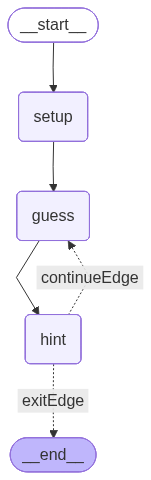

In [48]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [49]:
app.invoke({"playerName": "Student", "guesses": [], "attempts": 0, "lowerBound": 1, "upperBound": 20, "target": 13})

Hi Student !, attempt number: 1, choosing a number between 1 and 20.

Current guess: 19 

HINT: lower, new range = (1, 19) 

Current guess: 3 

HINT: upper, new range = (3, 19) 

Current guess: 19 

HINT: lower, new range = (3, 19) 

Current guess: 13 

HINT: Found it, target number: 13 at attempt: 4 



{'target': 13,
 'playerName': 'Student',
 'guesses': [19, 3, 19, 13],
 'attempts': 4,
 'lowerBound': 3,
 'upperBound': 19,
 'result': 'foundIt'}